In [1]:
from pprint import pprint
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential, activations
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def get_variables_and_size():
    from sys import getsizeof
    names = []
    sizes = []
    types = []
    for name in dir():
        # Print the item if it doesn't start with '__'
        if not name.startswith('__'):
            value = eval(name)
            names.append(name)
            sizes.append(getsizeof(value))
            types.append(type(value))
    sort_indexes = np.argsort(sizes)[::-1]
    names = np.array(names)[sort_indexes]
    sizes = np.array(sizes)[sort_indexes]
    types = np.array(types)[sort_indexes]
    for n,s,t in zip(names,sizes,types):
        print(n, "\n\tsize :", s, "\n\ttype :", t)

In [4]:
def get_normalization_infos(*x_s, columns):
    normalization_infos = pd.DataFrame(data=[[1000 for _ in range(len(columns))],[0 for _ in range(len(columns))]],
                                     index=["min","max"],
                                     columns=columns)
    for x in x_s :
        for col in columns:
            min_value = min(normalization_infos[col]["min"], x[col].min())
            max_value = max(normalization_infos[col]["max"], x[col].max())
            normalization_infos[col] = [min_value, max_value]

    normalization_infos.loc["spread"] = normalization_infos.apply(lambda c : c["max"] - c["min"], axis=0)

    return normalization_infos

def normalize(x : pd.DataFrame, normalization_infos : pd.DataFrame):
    for col in x.columns:
        x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]
    return x

In [5]:
def m_mape(y_true,y_predict):
    n = len(y_true)
    y_true = np.array(y_true) + 1
    y_predict = np.array(y_predict) + 1

    res = ((100/n)*(np.sum(np.abs((y_predict-y_true)/y_true))))
    return res

In [6]:
def box_plot(prediction_df):
    y_upper_bound = np.mean([prediction_df["ground_truth"].max(), prediction_df["Prediction"].max()])
    mape_score = m_mape(prediction_df["ground_truth"],prediction_df["Prediction"])

    plt.figure(figsize=(20,10))
    plt.suptitle("Prediction on 2017 data.")

    plt.subplot(2,3,1)
    plt.title("ground_truth")
    plt.boxplot(prediction_df["ground_truth"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,2)
    plt.title("Prediction. MAPE : {:.2f}".format(mape_score))
    plt.boxplot(prediction_df["Prediction"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,3)
    plt.boxplot(prediction_df["reg_pred"])
    plt.title("Regression only. MAPE : {:.2f}".format(m_mape(prediction_df["ground_truth"],prediction_df["reg_pred"])))
    plt.ylim([-0.01, y_upper_bound])

    plt.subplot(2,3,4)
    plt.hist(prediction_df[prediction_df["ground_truth"]<y_upper_bound]["ground_truth"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.subplot(2,3,5)
    plt.hist(prediction_df[prediction_df["Prediction"]<y_upper_bound]["Prediction"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.subplot(2,3,6)
    plt.hist(prediction_df[prediction_df["reg_pred"]<y_upper_bound]["reg_pred"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.show()

In [7]:
# Creating model using the Sequential in tensorflow
def build_model_classf(*layers, loss ='binary_crossentropy', metrics = ("AUC","accuracy"), learning_rate=0.001, last_activation="softmax"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(2, activation=last_activation))

    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=metrics
    )

    print(model.summary())
    return model

def make_cls_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="softmax"):
    # build the model
    model_cls = build_model_classf(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_cls = model_cls.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_cls = model_cls.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_cls,model_cls

def plot_history_cls(history, loss, key1, key2):
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])

    plt.subplot(1,3,2)
    plt.title("metric : {}".format(key1))
    plt.plot(history.history[key1])
    plt.plot(history.history['val_'+key1])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key1)
    plt.legend([key1, 'val_'+key1])

    plt.subplot(1,3,3)
    plt.title("metric : {}".format(key2))
    plt.plot(history.history[key2.lower()])
    plt.plot(history.history['val_'+key2.lower()])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key2)
    plt.legend([key2, 'val_'+key2])

    plt.suptitle("Classification results")
    plt.show()

In [8]:
# Creating model using the Sequential in tensorflow
def build_model_regrs(*layers, metric = MeanSquaredError(), learning_rate=0.001, last_activation="relu"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(1, activation=last_activation))

    model.compile(
        loss=metric,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[metric]
    )

    # print(model.summary())
    return model

def make_reg_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="relu"):
    # build the model
    model_reg = build_model_regrs(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_reg = model_reg.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_reg = model_reg.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_reg,model_reg

def plot_history_reg(history, loss : str):
    plt.figure(figsize=(7,5))
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])
    plt.show()

In [9]:
# custom activation functions
exp_relu = lambda x : activations.exponential(activations.relu(x)) - 1
square_relu = lambda x : activations.relu(x)**2

In [10]:
cluster_month_0 = [11,12,1,2,3,4]
cluster_month_1 = [5,6,7,8,9,10]

# Load the dataset

In [11]:
df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip")
# df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final.zip")
df_train["raining"] = df_train["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_train["not_raining"] = 1-df_train["raining"]

x_2016, y_reg_2016, y_cls_2016 = df_train, df_train["ground_truth"], df_train[["not_raining","raining"]].to_numpy()
del df_train

In [12]:
df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip")
# df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final.zip")
df_test["raining"] = df_test["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_test["not_raining"] = 1-df_test["raining"]

x_2017, y_reg_2017, y_cls_2017 = df_test, df_test["ground_truth"], df_test[["not_raining","raining"]].to_numpy()
del df_test

# merge 2016, 2017

In [13]:
x = pd.concat([x_2016,x_2017])
y_cls = np.concatenate([y_cls_2016, y_cls_2017])
y_reg = np.concatenate([y_reg_2016, y_reg_2017])

# get cluster 0 (c0) - cluster 1 (c1)

In [14]:
x["cluster"] = x["month"].apply(lambda x : 0 if x in cluster_month_0 else 1)

In [15]:
x_train, x_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(x,y_cls,y_reg, test_size=0.1, random_state=42)

In [16]:
prediction_x_test = pd.DataFrame(x_test[["Id","ground_truth", "month"]])

# drop unnecessary columns

In [17]:
# define the unnecessary columns
cols_to_drop = {"day","Id", "station_id","month","longitude_idx","latitude_idx", "next hour precipitation (kg/m^2)", "wind_direction (deg)", "ground_truth", "raining", "not_raining"}

In [18]:
#drop unnecessary columns
x_train.drop(list(set(x_train.columns)&cols_to_drop), axis=1, inplace=True)

In [19]:
#drop unnecessary columns
x_test.drop(list(set(x_test.columns)&cols_to_drop), axis=1, inplace=True)


# get same columns on both datasets

In [20]:
columns = list(x_train.columns)
x_train = x_train[columns]
x_test = x_test[columns]

# normalize both dataset with 2016 min and min-max values

In [21]:
normalization_infos = get_normalization_infos(x_train, x_test, columns=columns)
x_train = normalize(x_train, normalization_infos)
x_test = normalize(x_test, normalization_infos)

# see if the data is balanced raining-wise

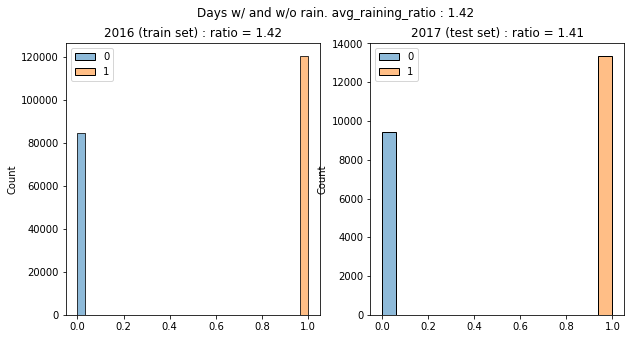

In [22]:
raining_ratio1 = y_cls_train[:,1].sum()/y_cls_train[:,0].sum()
raining_ratio2 = y_cls_test[:,1].sum()/y_cls_test[:,0].sum()
avg_raining_ratio = (raining_ratio1+raining_ratio2)/2

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(x=y_cls_train[:,1],hue=y_cls_train[:,1])
plt.title("2016 (train set) : ratio = {:.2f}".format(raining_ratio1))
plt.subplot(1,2,2)
sns.histplot(x=y_cls_test[:,1], hue=y_cls_test[:,1])
plt.title("2017 (test set) : ratio = {:.2f}".format(raining_ratio2))
plt.suptitle("Days w/ and w/o rain. avg_raining_ratio : {:.2f}".format(avg_raining_ratio))
plt.show()

ratio 2016 and 2017 ==> **Unbalanced**

# Classification Model (raining or not)
source : https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

In [23]:
with tf.device("cpu"):
    history_cls, model_cls = make_cls_model(
        Dense(64, activation="sigmoid",input_dim=x_train.shape[1]),
        Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        last_activation="sigmoid",
        x=x_train.values ,y=y_cls_train,
        epochs=300,
        batch_size=64,
        learning_rate=0.001
    )

2022-01-09 21:02:47.530316: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-09 21:02:47.530363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Y540
2022-01-09 21:02:47.530372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Y540
2022-01-09 21:02:47.530508: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-09 21:02:47.530547: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-09 21:02:47.530559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-09 21:02:47.531390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6336      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 10,594
Trainable params: 10,594
Non-traina

2022-01-09 21:02:47.939323: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68356568 exceeds 10% of free system memory.


2725/2725 [==============================] - 8s 2ms/step - loss: 0.6213 - auc: 0.7128 - accuracy: 0.6571 - val_loss: 0.6029 - val_auc: 0.7373 - val_accuracy: 0.6764
Epoch 2/300
2725/2725 [==============================] - 6s 2ms/step - loss: 0.6053 - auc: 0.7345 - accuracy: 0.6727 - val_loss: 0.5972 - val_auc: 0.7446 - val_accuracy: 0.6808
Epoch 3/300
2725/2725 [==============================] - 6s 2ms/step - loss: 0.5993 - auc: 0.7419 - accuracy: 0.6801 - val_loss: 0.6002 - val_auc: 0.7401 - val_accuracy: 0.6776
Epoch 4/300
2725/2725 [==============================] - 7s 3ms/step - loss: 0.5958 - auc: 0.7461 - accuracy: 0.6830 - val_loss: 0.5884 - val_auc: 0.7547 - val_accuracy: 0.6890
Epoch 5/300
2725/2725 [==============================] - 6s 2ms/step - loss: 0.5929 - auc: 0.7494 - accuracy: 0.6864 - val_loss: 0.5871 - val_auc: 0.7564 - val_accuracy: 0.6908
Epoch 6/300
2725/2725 [==============================] - 7s 3ms/step - loss: 0.5906 - auc: 0.7517 - accuracy: 0.6878 - val_loss

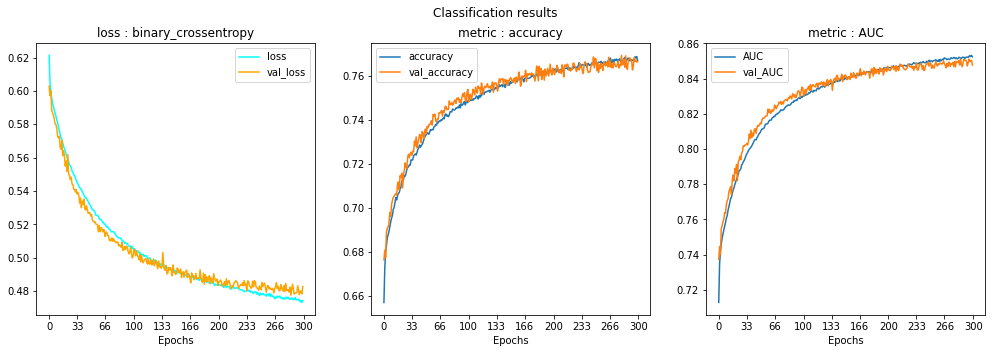

In [24]:
# Plot history
plot_history_cls(history_cls, loss = "binary_crossentropy", key1 = 'accuracy', key2 = 'AUC')

# Regression Model (how much rain if > 0)
source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [25]:
# reshape x_train and x_test
# x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
with tf.device("cpu") :
    history_reg, model_reg = make_reg_model(
        Dense(64, activation="sigmoid", input_dim=x_train.shape[1]),
        Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        x=x_train.values ,y=y_reg_train,
        last_activation=exp_relu,
        epochs=300,
        batch_size=64,
        learning_rate=0.001
    )

2022-01-09 21:33:11.661109: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68356568 exceeds 10% of free system memory.


Epoch 1/300
2725/2725 [==============================] - 6s 2ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 2/300
2725/2725 [==============================] - 5s 2ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0284 - val_mean_squared_error: 0.0283
Epoch 3/300
2725/2725 [==============================] - 5s 2ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 4/300
2725/2725 [==============================] - 5s 2ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 5/300
2725/2725 [==============================] - 5s 2ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 6/300
2725/2725 [==============================] - 5s 2ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 7/30

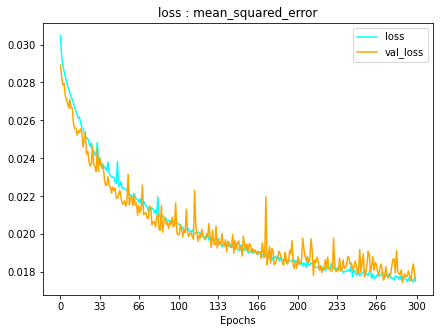

In [26]:
# Plot history
plot_history_reg(history_reg, 'mean_squared_error')

    # Compute MAPE on 2017 dataset before submitting

## classification

In [27]:
y_cls_pred = model_cls.predict(x_test)

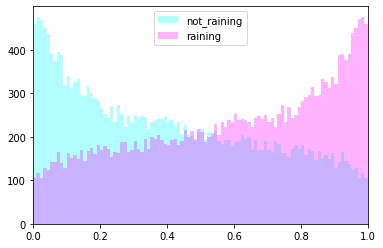

In [28]:
plt.hist(y_cls_pred[:,0], color="cyan", alpha=0.3, bins=100, label="not_raining")
plt.hist(y_cls_pred[:,1], color="magenta", alpha=0.3, bins=100, label="raining")
plt.xlim([0,1])
plt.legend()
plt.show()

In [29]:
y_cls_pred_bkp = np.array(y_cls_pred)

In [30]:
y_cls_pred = np.array(y_cls_pred_bkp)

In [31]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([0 if c else 1 for c in cls_temp])

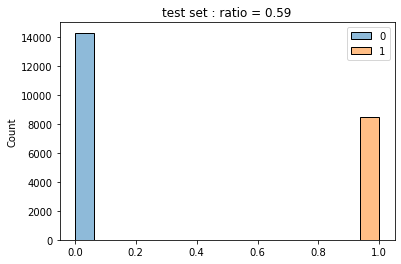

In [32]:
raining_ratio_pred = y_cls_pred.sum()/(len(y_cls_pred) - y_cls_pred.sum())
plt.title("test set : ratio = {:.2f}".format(raining_ratio_pred))
sns.histplot(x=y_cls_pred,hue=y_cls_pred)
plt.show()

## regression

In [33]:
y_reg_pred = model_reg.predict(x_test)

## merge

In [34]:
prediction_x_test["reg_pred"] = y_reg_pred
prediction_x_test["cls_pred"] = y_cls_pred
prediction_x_test["Prediction"] = prediction_x_test["reg_pred"] * prediction_x_test["cls_pred"]

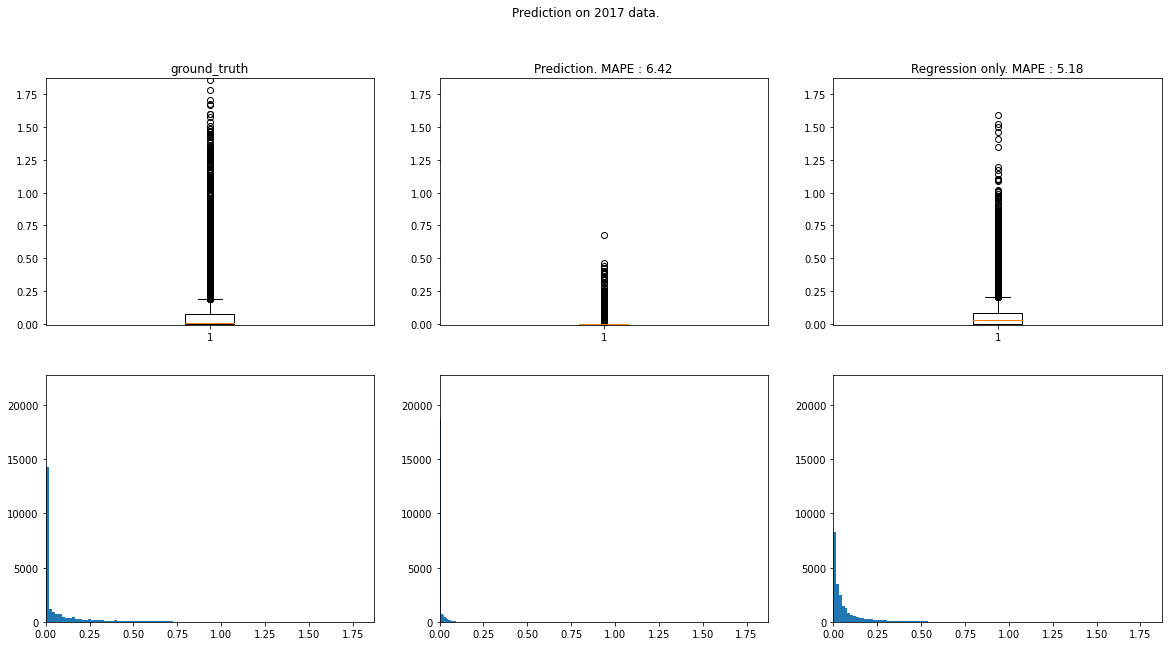

In [35]:
box_plot(prediction_x_test)

In [36]:
del x_train
del y_cls_train
del y_reg_train

In [37]:
del x_test
del y_cls_test
del y_reg_test

# Make a submission

In [38]:
test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final_by_day.zip")
# test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final.zip")

In [41]:
test_set["cluster"] = test_set["month"].apply(lambda x : 0 if x in cluster_month_0 else 1)

## create submission dataset

In [42]:
submission = pd.DataFrame(test_set[["Id"]])

## get same columns as before for test_set

In [43]:
test_set = test_set[columns]

## normalize same way test_set

In [44]:
test_set = normalize(test_set,normalization_infos)

/tmp/ipykernel_543773/2834267713.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]


In [45]:
test_set.head()

,altitude (m),latitude,longitude,month_cos,month_sin,current hour precipitations (kg/m^2),wind_direction_cos,wind_direction_sin,wind_speed (m/s),wind_component_u (m/s),...,3D_Arpege_isobar_600hpa_Geopotential (m^2/s^2),3D_Arpege_isobar_500hpa_Temperature (K),3D_Arpege_isobar_500hpa_RelavtiveHumidity (%),3D_Arpege_isobar_500hpa_WindSpeed (m/s),3D_Arpege_isobar_500hpa_WindDirection (deg),3D_Arpege_isobar_500hpa_WindComponentU (m/s),3D_Arpege_isobar_500hpa_WindComponentV (m/s),3D_Arpege_isobar_500hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_500hpa_Geopotential (m^2/s^2),cluster
0,0.152632,0.75,0.833333,0.000000,0.500000,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.944588,0.580973,0.679873,0.158791,0.679938,0.513694,0.603836,0.584511,0.948570,1.0
1,0.152632,0.75,0.833333,0.750000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.987683,0.851050,0.243663,0.169768,0.688638,0.520906,0.601052,0.569387,0.989601,0.0
2,0.152632,0.75,0.833333,0.933013,0.250000,0.09375,0.335841,0.972284,0.096735,0.43423,...,0.905300,0.271608,0.536040,0.349677,0.700741,0.613256,0.614223,0.542626,0.909959,0.0
3,0.152632,0.75,0.833333,0.250000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.894589,0.461949,0.822743,0.648840,0.583620,0.614184,0.950458,0.521686,0.907201,1.0
4,0.152632,0.75,0.833333,0.066987,0.250000,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.947055,0.602551,0.339574,0.163890,0.669567,0.503793,0.610642,0.536338,0.950927,1.0


## Predict test_set for submission

In [54]:
y_cls_pred = model_cls.predict(test_set)

2022-01-09 22:00:29.787299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 92492400 exceeds 10% of free system memory.


In [55]:
y_reg_pred = model_reg.predict(test_set)

KeyboardInterrupt: 

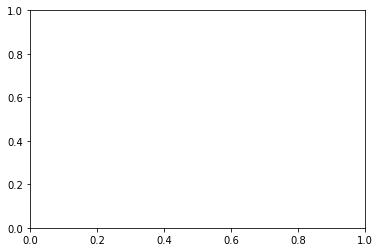

In [56]:
sns.histplot(x=y_cls_pred[:,1], hue=y_cls_pred[:,1])
plt.show()

In [57]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([0 if c else 1 for c in cls_temp])

In [58]:
print(avg_raining_ratio)

1.4187411744200722


In [59]:
submission["cls_pred"] = y_cls_pred
submission["reg_pred"] = y_reg_pred

In [60]:
submission["Prediction"] = submission["cls_pred"] * submission["reg_pred"]

In [61]:
submission.head(25)

,Id,cls_pred,reg_pred,Prediction
0,14047002_1,0,0.192093,0.000000
1,14047002_10,1,0.000000,0.000000
2,14047002_100,0,0.165368,0.000000
3,14047002_101,0,0.532374,0.000000
4,14047002_102,0,0.103798,0.000000
5,14047002_103,0,0.010929,0.000000
6,14047002_104,0,0.073143,0.000000
7,14047002_105,0,0.015242,0.000000
8,14047002_106,0,0.234708,0.000000
9,14047002_107,0,0.275839,0.000000


In [62]:
submission[["Id","Prediction"]].to_csv("./submission_ann_reg_cls.csv", index=False)

In [63]:
submission2 = submission.drop(["Prediction","cls_pred"], axis=1)
submission2.rename(columns={"reg_pred": "Prediction"}, inplace=True)

In [64]:
submission2.head()

,Id,Prediction
0,14047002_1,0.192093
1,14047002_10,0.000000
2,14047002_100,0.165368
3,14047002_101,0.532374
4,14047002_102,0.103798


In [65]:
submission2[["Id","Prediction"]].to_csv("./submission_ann_reg.csv", index=False)